In [1]:
#import various python libraries
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import pyklip.klip as klip
import astropy.stats as aps
import glob
import pyklip.rdi as rdi
import pyklip
import pyklip.instruments.GPI as GPI
import pyklip.parallelized as parallelized
from importlib import reload
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
#we will use some functionality from the PyKLIP package. 
#Run this cell if you don't already have it installed
#!pip install pyklip 

In [3]:
# a few simple plotting functions that we will use throughout

def add_label(ax,txt,imsz):
    """
    Simple function to add a label to the bottom left corner of images
    """
    ax.text(5,imsz-10,txt,c='w',size=18)

def add_cbar(im, ax, f, lb="counts"):
    """
    Simple function to add a colorbar
    """
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    f.colorbar(im, cax=cax, orientation='vertical', label=lb)

def set_display(stampsz,stampcen=None, tickint=0.5):
    """
    Simple function to convert coordinates to arcseconds and display them over the right range
    """
    #assume center is the center of the image if not provided
    if stampcen == None:
        stampcen = ((stampsz - 1)/2.,(stampsz - 1)/2.)
    #define boundaries of a stamp around center
    mnx=int(stampcen[0]-stampsz/2)
    mxx=int(stampcen[0]+stampsz/2+1)
    mny=int(stampcen[1]-stampsz/2)
    mxy=int(stampcen[1]+stampsz/2+1)
    #package into one object
    ranges=(mnx,mxx,mny,mxy)
    platescale=.01414 #GPI platescale in arcsec
    #set an appropriate number of ticks
    nticks = np.floor(stampsz*platescale/2/tickint)
    #define tick labels
    ticklabels = np.arange(-1*nticks, nticks+1)*tickint
    ticklabels_str = [str(lab)+'\"' for lab in ticklabels]
    #and tick locations
    ticks = ticklabels/platescale + stampsz/2
    return(ranges, ticks, ticklabels_str)

## Introduction

This notebook accompanies the PASP tutorial "An Introduction to High Contrast Differential Imaging of Exoplanets and Disks" by Kate Follette. 

Its goal is to provide simple worked examples of "classical" versions of each of the main HCI differential imaging techniques. These are:
1. Polarized Differential Imaging (PDI)
2. Reference Differential Imaging (RDI)
3. Angular Differential Imaging (ADI)
4. Spectral Differential Imaging (SDI)

It is worth noting that these "classical" reduction examples are far less sophisticated than what is typically done in modern HCI processing pipelines, and all of the final output images can and should be improved before making detailed inferences about spectral, morphological, or photometric characteristics of the dataset. The exercises are designed to build intuition and NOT to serve as a cookbook for HCI processing. 

Most modern high-contrast imaging involves processing through a relatively small number of dedicated software packages, where much more of the data processing framework is hidden. The examples in this notebook mostly utilize simple inline processing functions; however, in cases such as image alignment (which are beyond the scope of this notebook to demonstrate), it utilizes several pieces of functionality from the [pyKLIP](https://pyklip.readthedocs.io/en/latest/index.html) software library, an open-source python package designed for high-contrast imaging with integral field spectrographs. Other packages with similar functionality include
[PynPoint](https://pynpoint.readthedocs.io/en/latest/index.html) and [VIP](https://vip.readthedocs.io/en/v1.4.0/#).

All data provided for and processed in this notebook were collected as part of the [Gemini Planet Imager Exoplanet Survey](http://planetimager.org/). In particular, this notebook utilizes the following datasets:
1. K-band polarimetric and H-band spectroscopic images of the debris disk HR4796A (see [Arriaga+ 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160...79A/abstract))
2. H-band spectroscopic images of the star Beta Pictoris and it's planetary companion Beta Pic b (see [Chilcote+ 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...798L...3C/abstract))
3. H-band spectroscopic images of the star 51 Eri and it's planetary companion 51 Eri b (see [Macintosh+ 2015](https://ui.adsabs.harvard.edu/abs/2015Sci...350...64M/abstract) and [Rajan+ 2017](https://ui.adsabs.harvard.edu/abs/2017AJ....154...10R/abstract))

Further details and more advanced processing and analysis for each of these datasets can be found in the linked publications

# 1. Classical Polarized Differential Imaging (PDI) 
## Target = Debris disk HR 4796 A at K-band (2.2$\mu$m)

This exercise utilizes a simple, classical approach to Polarized Diffirential Imaging by computing Stokes I, Q, and U images, as well as a polarized intensity (PI) image. A more common modern approach is to generate the "radially polarized" images Q$_\phi$ and U$_\phi$. 

GPI data pipeline reductions for this dataset were conducted originally by Maxwell Millar-Blanchaer.

In [4]:
#pointer to the data directory
pdidatadir = 'HR4796A_140422_K1_pol/'

In [5]:
## Read in a cycle of individual images at 4 half-waveplate orientations
psn1 = fits.getdata(pdidatadir+'S20140422S0305_podc.fits') #0deg
head = fits.getheader(pdidatadir+'S20140422S0305_podc.fits', ext=1)
psn2 = fits.getdata(pdidatadir+'S20140422S0306_podc.fits') #22.5deg
psn3 = fits.getdata(pdidatadir+'S20140422S0307_podc.fits') #45deg
psn4 = fits.getdata(pdidatadir+'S20140422S0308_podc.fits') #67.5deg

In [6]:
stampsz=140
center = (head["PSFCENTX"],head["PSFCENTY"])
rg, ticks, ticklabels_str = set_display(stampsz,stampcen=center)
mnx,mxx,mny,mxy=rg

Let's look first at the two simultaneously-obtained orthogonal polarization states

(2, 281, 281)


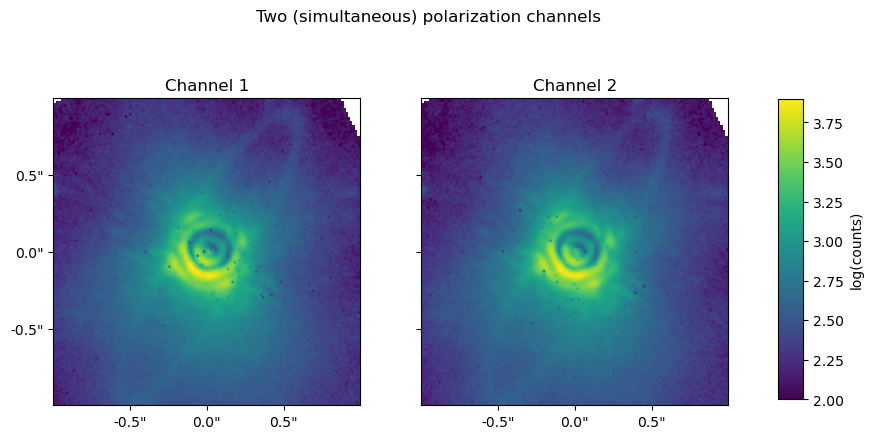

In [7]:
## some details about what's in here
print(psn1.shape) #dimension 0 = 2 because there are 2 polarization channels

#now show images
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
im1 = ax1.imshow(np.log10(psn1[0,mnx:mxx,mny:mxy]), origin='lower', vmin=2)
ax1.set_title("Channel 1")
im2 = ax2.imshow(np.log10(psn1[1,mnx:mxx,mny:mxy]), origin='lower', vmin=2)
ax2.set_title("Channel 2")
plt.setp(ax1, xticks=ticks, xticklabels=ticklabels_str, yticks=ticks, yticklabels=ticklabels_str)
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.2, 0.025, 0.6])
f.colorbar(im1, cax=cbar_ax,label="log(counts)")
t = f.suptitle('Two (simultaneous) polarization channels')

The images above should look nearly identical. In fact, the change in bad pixels locations in the two regions of the detector is perhaps the principle noticeable difference between them. In reality, light from the (unpolarized) star, for which the Wollaston prism splitting the light into two polarization states is acting like a 50/50 beamsplitter, is virtually identical between them. There are subtle differences, however, in the disk brightness because disk scattered light is polarized. These differences are not easily seen in the images above, so let's subtract the opposing polarization images (shown above for the 0deg waveplate orientation) for each of the four waveplate rotations to better visualize the differences. This is also how we create Stokes Q, -Q, U, and -U images.

In [8]:
## subtract opposing polarization channels to create Q, -Q, U, -U
q = psn1[0,:,:]-psn1[1,:,:]
negq = psn3[0,:,:]-psn3[1,:,:]
u = psn2[0,:,:]-psn2[1,:,:]
negu = psn4[0,:,:]-psn4[1,:,:]

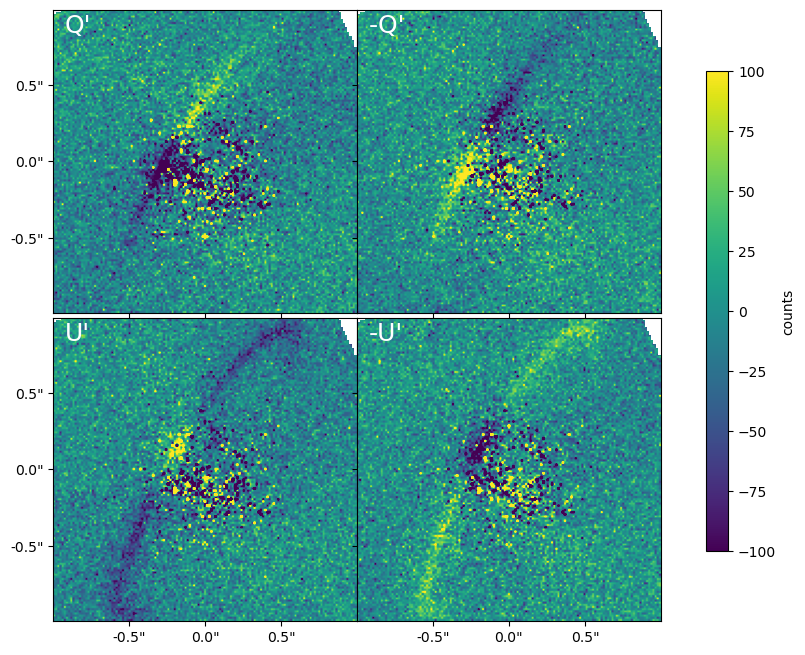

In [9]:
##show the channel difference images
f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9,8))
im1 = ax1.imshow(q[mnx:mxx,mny:mxy], origin='lower', vmin=-100, vmax=100)
add_label(ax1,"Q'",stampsz)
im2 = ax2.imshow(negq[mnx:mxx,mny:mxy], origin='lower', vmin=-100, vmax=100)
add_label(ax2,"-Q'",stampsz)
im3 = ax3.imshow(u[mnx:mxx,mny:mxy], origin='lower', vmin=-100, vmax=100)
add_label(ax3,"U'",stampsz)
im4 = ax4.imshow(negu[mnx:mxx,mny:mxy], origin='lower', vmin=-100, vmax=100)
add_label(ax4,"-U'",stampsz)
plt.setp(ax1, xticks=ticks, xticklabels=ticklabels_str, yticks=ticks, yticklabels=ticklabels_str)
plt.subplots_adjust(wspace=0, hspace=0)
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.2, 0.025, 0.6])
cb = f.colorbar(im1, cax=cbar_ax,label="counts")

These difference images reveal that there is subtle variation in the strength and location of polarized light between the two simultaneously-obtained orthogonal polarization channels. Direct starlight, on the other hand, is very effectively removed. 

We can now average the Q and -Q, U and -U images in order to minimize detector location-specific artifacts and acheive a better estimate of the Stokes Q and U images. While we're at it, we can also add the images across waveplate orientations for each polarization channel and average them to acheive a total intensity image, which should be dominated by starlight as it represents the sum of all light entering the detector regardless of polarization state. 

In [10]:
#Now, average Q and -Q, U and -U together
bigq = (q - negq)/2
bigu = (u - negu)/2

In [11]:
#and create a total intensity image as well by averaging across the 4 waveplate orientations
#for each channel
i = (psn1[0,:,:]+psn2[0,:,:]+psn3[0,:,:]+psn4[0,:,:])/4
i2 = (psn1[1,:,:]+psn2[1,:,:]+psn3[1,:,:]+psn4[1,:,:])/4
#now average the channels
bigi = (i+i2)/2

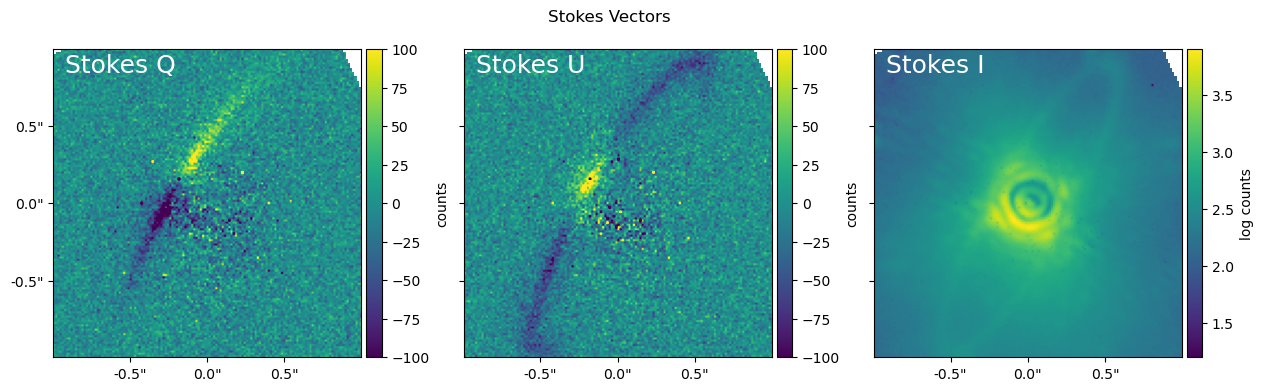

In [12]:
#now show the three Stokes images we can measure - Q, U, and I (not V)
f, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,4))
im1 = ax1.imshow(bigq[mnx:mxx,mny:mxy], origin='lower', vmin=-100, vmax=100)
add_cbar(im1,ax1,f)
add_label(ax1, 'Stokes Q',stampsz)
im2 = ax2.imshow(bigu[mnx:mxx,mny:mxy], origin='lower', vmin=-100, vmax=100)
add_cbar(im2,ax2,f)
add_label(ax2, 'Stokes U',stampsz)
im3 = ax3.imshow(np.log10(bigi[mnx:mxx,mny:mxy]), origin='lower')
add_cbar(im3,ax3,f, lb="log counts")
add_label(ax3, 'Stokes I',stampsz)
plt.setp(ax1, xticks=ticks, xticklabels=ticklabels_str, yticks=ticks, yticklabels=ticklabels_str)

t = f.suptitle('Stokes Vectors')

Stokes Q and U images can then be combined to form a total polarized intensity image, following the formula

$$PI = \sqrt{Q^2+U^2}$$

This image can be compared to the starlight-subtracted total intensity image of the disk to compute a polarization fraction. After running through the other worked examples, I suggest attempting PSF subtraction on the total intensity imagery to compute a map of the polarization fraction.   

In [13]:
#combine Q and U to make polarized intensity image
PI = np.sqrt(bigq**2+bigu**2)

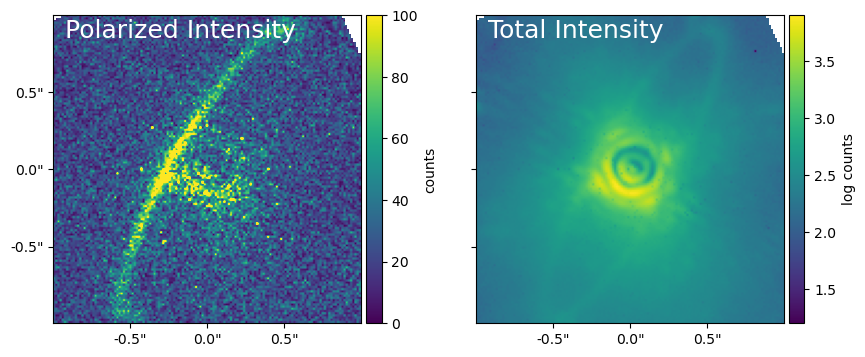

In [14]:
##and compare to total intensity
f, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,4))
im1 = ax1.imshow(PI[mnx:mxx,mny:mxy], origin='lower', vmin=0, vmax=100)
add_cbar(im1,ax1,f)
add_label(ax1, 'Polarized Intensity', stampsz)
im2 = ax2.imshow(np.log10(bigi[mnx:mxx,mny:mxy]), origin='lower')
add_cbar(im2,ax2,f, lb="log counts")
add_label(ax2, 'Total Intensity', stampsz)
lb = plt.setp(ax1, xticks=ticks, xticklabels=ticklabels_str, yticks=ticks, yticklabels=ticklabels_str)

Uncomment the cell below to generate .fits format images of the main PDI output arrays for examination in more detail with a fits viewer (such as DS9). Similar cells are not provided in the remaining 3 sections of the notebook, however I highly suggest writing similar code and examining the .fits images of the intermediate and final stages in each diffirential imaging process. Exploring the images across their full dynamic range, examining changes through any additional (e.g. wavelength) dimensions, and blinking among images are some of the best ways to develop intuition about these techniques. 

In [15]:
#fits.writeto('Q.fits',q)
#fits.writeto('negQ.fits',negq)
#fits.writeto('U.fits',u)
#fits.writeto('negU.fits',negu)
#fits.writeto('bigq.fits',bigq)
#fits.writeto('bigu.fits',bigu)
#fits.writeto('bigI.fits',bigi,overwrite=True)

## Exercise 1: Practice PDI

Apply the procedure above to generate your own Polarized Intensity and Total Intensity images from any *other* set of 4 images with the correct range of waveplate orientation angles (preferably a set of 4 near the end of the sequence). Subtract your PI image from mine. Do the same for your total intensity image, and plot the resulting subtractions. What does this tell you about what else is happening throughout the image sequence? Do all the features line up? why or why not? 

*Hint: The orientation of the half-waveplate is captured in the "WPANGLE" header keyword in the ***first*** (index=0) fits header extension for each image. To read in that part of the header, use something like:*
head2 = fits.getheader(pdidatadir+'S20140422S0305_podc.fits', ext=0)

*Challenge Exercises*: 

1. So far in this section, we have computed Stokes images for a *single* sequence of four waveplate rotations. Write your own PDI function to compute Stokes images for *all* of the waveplate rotation sequences in the provided data directory. You may wish to generate a function for this purpose, along the same lines as the functions provided in the later sections of this notebook. You will have to adapt code from later exercises to solve the problem that you identified in the images you created in the first exercise. The output should be PI and I images that represent the combination, average, or median of all PI and I images that can be generated for this dataset.  

2. After reviewing the remainder of this tutorial, come back to this section and perform PSF subtraction on the total intensity imagery for this dataset. Use it to compute a map of the estimated polarization fraction P (PI/I) for the grains. Note that, without a throughput correction, this fraction will be an overestimate if there is significant self-subtraction, so a conservative method is advisable.   

In [16]:
#your code here

# 2. (Classical) Reference Differential Imaging (RDI)

## Target = Debris disk HR 4796 A at H-band (1.65$\mu$m)

This section demonstrates the process of classical Reference Differential Imaging using H-band GPI images of the HR 4796A debris disk. It was processed with the GPIES automatic reduction pipeline. 

As outlined in detail in the main tutorial, Reference Differential Imaging leverages images of one or more PSF reference stars to construct an estimate of the PSF of the target images.

In [17]:
rdi_datadir = 'HR4796A_20160318_H_Spec/'

In [18]:
PSF_ims = glob.glob(rdi_datadir + 'PSF1/*spdc_distorcorr.fits')
sci_ims = glob.glob(rdi_datadir + '*spdc_distorcorr.fits')

In [19]:
def cRDI_GPI(PSF_ims, sci_ims):
    """
    Very simple classical reference differential imaging function for GPI IFS data. Collapses
    the data in the wavelength dimension before collapse.
    
    required inputs:
        PSF_ims = string list of filenames for one or more PSF reference stars
        sci_ims = string list of filenames for images of the target 
    
    output:
        final_RDI = cRDI subtracted image
        final_noRDI = derotated and median-combined, but NOT PSF subtracted image for comparison
    """
    
    #read in these data as a pyKLIP dataset object 
    #not going to run KLIP. Just so we can use align and spectral collapse functionality
    PSF_dataset = GPI.GPIData(sorted(PSF_ims), quiet=True) #, highpass=True)

    #collapse the image cubes across H-band. Will also align.
    GPI.Data.spectral_collapse(PSF_dataset,aligned_center=[150,150])
    #make a simple median PSF 
    medPSF = np.nanmedian(PSF_dataset.input, axis=0)
    
    #read in science data, align, and collapse
    sci_dataset = GPI.GPIData(sorted(sci_ims), quiet=True) #, highpass=True)
    GPI.Data.spectral_collapse(sci_dataset,aligned_center=[150,150])
    
    #PSF subtraction
    subims=np.zeros(sci_dataset.input.shape)
    derotims=np.zeros(sci_dataset.input.shape)
    derotsubims=np.zeros(sci_dataset.input.shape)
    for i in np.arange(sci_dataset.input.shape[0]):
        #create a simple normalization factor to scale the amplitude of the PSF to match
        normfac = (np.nanmedian(sci_dataset.input[i,130:170,130:170])/np.nanmedian(medPSF[130:170,130:170]))
        #subtract scaled PSF
        subims[i,:,:] = sci_dataset.input[i,:,:]-medPSF*normfac
        subims[i,:,:]-=np.nanmedian(subims[i,:,:]) #make zero median
        #derotate the subtracted images
        derotsubims[i,:,:] = klip.rotate(subims[i,:,:],sci_dataset.PAs[i],(150,150))
        #and for comparison, derotate the unsubtracted images
        derotims[i,:,:] = klip.rotate(sci_dataset.input[i,:,:],sci_dataset.PAs[i],(150,150))
    #median collapse derotated frames
    final_RDI = np.nanmedian(derotsubims,axis=0)
    final_noRDI = np.nanmedian(derotims,axis=0)
    return(final_RDI, final_noRDI)

In [20]:
#run the function to generate the RDI and non-RDI images
crdi_im, nordi_im = cRDI_GPI(PSF_ims, sci_ims)

/Users/kfollette/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/kfollette/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


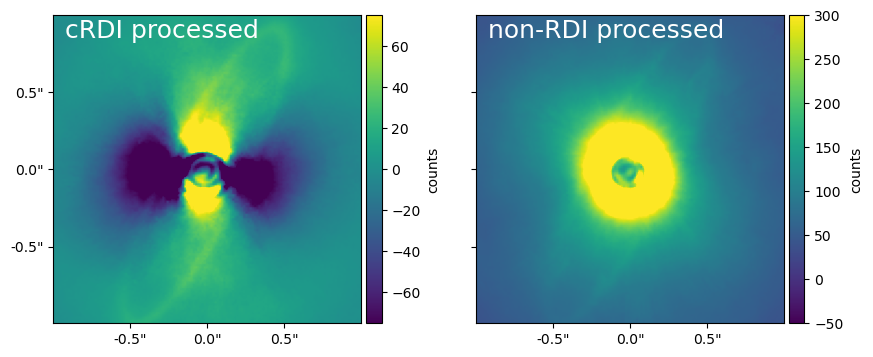

In [21]:
##visualize the output
f, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,4))
im = ax1.imshow(crdi_im[mnx:mxx,mny:mxy], vmin=-75, vmax=75, origin='lower')
im2 = ax2.imshow(nordi_im[mnx:mxx,mny:mxy], vmin=-50, vmax= 300, origin='lower')
plt.xticks(ticks, labels = ticklabels_str) 
plt.yticks(ticks, labels = ticklabels_str) 
add_cbar(im,ax1,f)
add_cbar(im2,ax2,f)
add_label(ax1, 'cRDI processed', stampsz)
add_label(ax2, 'non-RDI processed', stampsz)

Mismatch between the reference PSF and the HR 4796A PSF is apparent here in the butterfly-like residuals at the center of the lefthand image. Comparison with the righthand image (particularly if you compare the counts), makes apparent the fact that most of the starlight has been removed, resulting in a clearer detection of the disk. 

## Exercise 2 - Practice RDI

There are several simple things that can be done to improve this subtraction. Work through the following examples and  create a multipanel plot showing the outcomes of your experiments. Then, write 1-2 paragraphs summarizing what you've learned about what makes for an effective RDI subtraction. 

**Experiment 1: Choose an alternate reference star**  
What happens if you choose an alternate PSF reference star? The directory containing these data contain an additional directory of PSF reference star images titled "PSF2". Try reducing the data with this reference star and plot the resulting subtraction next to the one I generated above. What does this comparison tell you about choosing reference stars for RDI processing?  

**Experiment 2: Choose more than one reference star**  
Now, put the two reference stars in the *same* directory (a new one that you create) and run a reduction with both. Does it improve the subtraction (i.e. is the HR4796A ring more clearly defined all the way around or easier to pick out)? Why or why not?  

**Experiment 3: Try highpass filtering**  
Differences in the extended halo of light around the star are the source of much of the PSF mismatch between the reference stars and the target images. One effective way to remove this and improve the match between them is to highpass filter the images. To turn on highpass filtering\*, add the argument highpass=True (currently commented out) to both GPI.GPIData calls. What looks different here? 

**Experiment 4: Try different sizes of highpass filter**  
You can also run highpass filtering with a numbered argument (e.g. highpass=10) instead of highpass=True. This number corresponds approximately to the size of a gaussian highpass filter. Experiment with its value. How do large and small values of this argument compare? What value or range of values do you think is best in this context and why? 

**Experiment 5: Choose your own adventure**  
Play around with other ways to improve the subtractions. For example, you might improve the simple manipulations in the cRDI_GPI function that normalize the images or make them zero median. Can you improve the final result?

\* see the tutorial article for more details on highpass filtering

In [22]:
#your code here

# 3. Classical Angular Differential Imaging (cADI) 
## Target = exoplanet Beta Pictoris b at H-band (1.65$\mu$m)

This section demonstrates the process of classical Angular Differential Imaging using GPI images of the exoplanet Beta Pictoris b originally reducted by Jason Wang. 

Although much more sophisticated means of Angular Differential Imaging exist, cADI images still frequently appear in the literature as a form of conservative reduction of a HCI dataset. 

As outlined in greater detail in the main tutorial, ADI processing involves leveraging the fact that the orientation of the instrumental PSF is static in the instrument frame of reference, while a disk or exoplanet's orientation is static in a different reference frame - the frame of the sky. In most astronomical imaging, an instrument rotator compensates for on-sky rotation and keeps these two frames of reference aligned throughout an image sequence. However, in the case of ADI, this instrument rotator is turned off so that the two reference frames are allowed to rotate with respect to one another. 

Given a sufficient amount of on-sky rotation, which moves the exoplanet through the instrument frame during the image sequence, this allows us to median-combine in the static instrument frame to get a reference stellar PSF for subtraction/removal. Because subtracted images must then be rotated to a common on-sky frame of reference to combine and build up planet/disk signals, rotation angles must be carefully tracked. 

In [23]:
#define data directory and read in files
cadi_datadir = 'BetPic_20131118_H_Spec/'
flist_raw = glob.glob(cadi_datadir+'*distorcorr_.fits')
flist=sorted(flist_raw)

In [24]:
#new image boundaries and parameters
stampsz=100
rg, ticks, ticklabels_str = set_display(stampsz, stampcen=(140,140))
mnx,mxx,mny,mxy=rg

In [25]:
def cADI_GPI(flist, write_intermediate=False):
    """
    Very simple classical angular differential imaging function for GPI IFS data. 
    Preserves the wavelength dimension of the GPI images, which could also be collapsed
    prior to reduction.
    
    required inputs:
        flist = string list of filenames for a GPI ADI sequence of images
    
    optional inputs:
        write_intermediate = saves fits files of intermediate steps of the reduction for visual
                             inspection
    
    output:
        med_derot = cADI image cube (wavelength dimension preserved)
        med_derot_noadi = derotated and median-combined, but NOT PSF subtracted image for comparison

    """
    ##create 3 blank arrays to store intermediate steps, which can be displayed to build intuition
    newarr = np.zeros((len(flist),37,281,281))
    subarr = np.zeros((len(flist),37,281,281))
    derot = np.zeros((len(flist),37,281,281))
    derot_noadi = np.zeros((len(flist),37,281,281))
    ##create a list to store the vertical angles for the images, needed to orient them
    vertang=[]
    ctrs=[]
    ##turn the file list into a data cube, and store the vertical angles
    for i in np.arange(len(flist)):
        newarr[i,:,:,:]=fits.getdata(flist[i])
        head2 = fits.getheader(flist[i],ext=1)
        pa=head2["AVPARANG"]
        center = (head2["PSFCENTX"],head2["PSFCENTY"]) #same for all ims
        ctrs.append(center)
        vertang.append((-(pa) + (90-23.5))) #23.5 is the IFS rotation angle
    #create the median image (PSF)
    medarr = np.nanmedian(newarr,axis=0)
    #subtract this median image from each image in the sequence
    for i in np.arange(len(flist)):
        #subtract median PSF
        subarr[i,:,:,:]=newarr[i,:,:,:]-medarr
        #derotate the images
        for wl in np.arange(37):
            derot[i,wl,:,:] = klip.rotate(subarr[i,wl,:,:],vertang[i],ctrs[i],new_center=(140,140))
            derot_noadi[i,wl,:,:] = klip.rotate(newarr[i,wl,:,:],vertang[i],ctrs[i],new_center=(140,140))
    #median combine
    med_derot=np.nanmedian(derot,axis=0)
    med_derot_noadi=np.nanmedian(derot_noadi,axis=0)
    if write_intermediate:
        fits.writeto('imarray.fits',newarr, overwrite=True)
        fits.writeto('imarray_PSFsub.fits', subarr, overwrite=True)
        fits.writeto('imarray_PSFsub_derot.fits', derot, overwrite=True)
    return(med_derot, med_derot_noadi)

In [26]:
#execute the function for this dataset
cadi_im, nocadi_im = cADI_GPI(flist, write_intermediate=False)

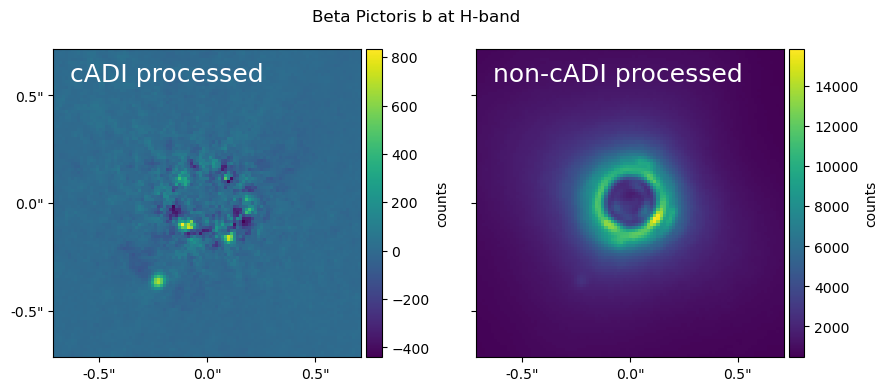

In [27]:
#select a wavelength to view
wslice = 15 #change to see other wavelengths in the cube

##visualize the output
f, (ax1,ax2) = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,4))
f.suptitle("Beta Pictoris b at H-band")
im = ax1.imshow(cadi_im[wslice,mnx:mxx,mny:mxy], origin='lower')
im2 = ax2.imshow(nocadi_im[wslice,mnx:mxx,mny:mxy], origin='lower')
plt.xticks(ticks, labels = ticklabels_str) 
plt.yticks(ticks, labels = ticklabels_str) 
add_cbar(im,ax1,f)
add_cbar(im2,ax2,f)
add_label(ax1, 'cADI processed', stampsz)
add_label(ax2, 'non-cADI processed', stampsz)

## Exercise 3 - Practice cADI

The files provided for this tutorial include images of another directly-imaged exoplanet, 51 Eridani b. Use the code provided above as an example to read in and process these data, then make a 2 panel image showing it and Beta Pic side-by-side at several different wavelengths. Though these data are not throughput-corrected and therefore not appropriate for detailed photometry/spectroscopy, the amount of self-subtraction is roughly consistent among wavelengths, so relative brightnesses among wavelengths for a single object are representative of the spectrum of the object. What differences do you notice between the brightnesses of the two objects as you move through the image cube?

*Challenge Exercise: Extract a "quick and dirty" spectrum from each object (e.g. by taking the peak pixel or summing over a small box around the planet) and compare them. How are the spectra of the two objects different? Can you link this to the characteristics of the L and T spectral classes?*

In [28]:
#your code here

# 4. Spectral Differential Imaging (SDI)
## Target = exoplanet Beta Pictoris b at H-band (1.65$\mu$m)

The final form of differential imaging, and the one least amenable to a "classical" approach for reasons that will become clear through the exercises below, is Spectral Differential Imaging. As outlined in the full article, SDI leverages the wavelength dimension of an integral field spectrograph data cube to estimate the PSF of the central star. It takes advantage of the fact that the stellar PSF is magnified as wavelength increases. Rescaling images to "undo" this magnification effectively moves real on-sky signals inward or outward radially because, unlike the stellar PSF, their location on the detector does not change with wavelength. Rescaling the images to make their PSFs align thus moves planet/disk signals out of alignment, allowing for PSF estimation by median combining across wavelengths in the rescaled image cube. This wavelength-medianed PSF is constructed and subtracted for each individual IFS image cube, and the rescaling to the common PSF frame is then undone to place everything back in a common on-sky orientation. These PSF-subtracted individual images at each wavelength can then be combined in the sky-frame to construct images of the planet at each wavelength and, ultimately, a spectrum can be extracted. 

SDI imaging is virtually never done in isolation, and almost never in the "classical" (simple median combination) sense in which it is presented here. Instead, it is nearly always (a) done in tandem with ADI and (b) done utilizing an estimate of the planetary spectrum, which allows for a weighting of wavelengths according to how strong the planetary signal is expected to be. 

For purposes of illustrating the effects of SDI alone, though the instrument rotator is off in the image sequence treated below, this worked example utilizes *only the spectral dimension* of the IFS image cubes to construct a PSF for each one, and does not utilize the time dimension (and therefore rotation) to construct PSFs. 

These data effectively highlight a challenge of SDI-only processing, which is that over the relatively narrow wavelength range of a typical IFS cube, the PSF rescaling is modest and the planet is shifted only a few pixels radially. This means that, though a simple median combination of the wavelength-rescaled images results in signal at the location of a planet candidate, it is often extremely self-subtracted. The worked example below utilizes several possibilities for the wavelength collapse.

In [29]:
def cSDI_GPI(flist, psfcombo='brute'):
    """
    Very simple classical spectral differential imaging function for GPI IFS data. 
    
    required inputs:
        flist = string list of filenames for a GPI SDI sequence of images
    
    optional inputs:
        psfcombo = method of collapsing the rescaled cube in wavelength space to construct
                   a PSF. Options are 'median', 'mean', 'clipped-mean', and 'brute'. 
    
    output:
        medcollapse = cSDI image cube with dimensions (nimages, nwavelengths, imsz, imsz)
    """ 
    newimcube=np.zeros((len(flist),37,281,281))
    cens=[]
    wls=[]
    vertangs=[]
    #rescale images to common PSF reference frame
    for i in np.arange(len(flist)):
        #read in image
        cube=fits.getdata(flist[i])
        #and header
        head=fits.getheader(flist[i], ext=1)
        #record center (for rotation later)
        cenx = head["PSFCENTX"]
        ceny = head["PSFCENTY"]
        cens.append((cenx,ceny))
        #construct a list of wavelengths for the images from header info
        ch1 = head['CRVAL3']
        step = head["CD3_3"]
        wlist = ch1+step*np.arange(37)
        wls.append(wlist)
        #read in rotation angles for later
        pa=head["AVPARANG"]
        vertang=-(pa) + (90-23.5)
        vertangs.append(vertang)
        for j in np.arange(37):
            #utilize the align_and_scale klip fuction to rescale the images 
            #choosing to scale all images up to the longest wavelength of the cube (wls[-1])
            newimcube[i,j,:,:]=klip.align_and_scale(cube[j,:,:],(cenx,ceny), scale_factor=wlist[-1]/wlist[j])

    #make a PSF
    PSF=construct_SDI_PSF(newimcube, psfcombo)  
    subimcube = np.ones((len(flist),37,281,281))
    rescalecube = np.ones((len(flist),37,281,281))
    derotcube = np.ones((len(flist),37,281,281))
    
    #subtract PSF from all images in PSF frame, then rescale & rotate to sky frame
    for i in np.arange(len(flist)):
        for j in np.arange(37):
            #create a simple normalization factor to scale the amplitude of the PSF to match
            normfac =np.nanmedian(newimcube[i,j,120:160,120:160])/np.nanmedian(PSF[i,120:160,120:160])
            #subtract this scaled PSF
            subimcube[i,j,:,:]=newimcube[i,j,:,:]-PSF[i,:,:]*normfac
            #rescale to instrument frame
            rescalecube[i,j,:,:]=klip.align_and_scale(subimcube[i,j,:,:],cens[i], scale_factor=wls[i][j]/wls[i][-1])
            #rotate to sky frame
            derotcube[i,j,:,:] = klip.rotate(rescalecube[i,j,:,:],vertangs[i],cens[i])
   
    #create a median-combined PSF from the 
    medcollapse = klip.collapse_data(derotcube,axis=0,collapse_method='median') 
    return(medcollapse)

def construct_SDI_PSF(cube, method):
    """
    Function to construct an SDI reference PSF for subtraction according to one of 4 methods
    
    required inputs:
        cube = a cube of SDI images of the form (nimages, nwavelengths, imsz, imsz)
        method = a string specifying how the reference PSF should be constructed when collapsing
                 in wavelength space. Options are 'median', 'mean', 'clipped-mean', and 'brute'.
                 Median and median are simple collapses. Clipped-mean performs sigma-clipping
                 before collapse. "Brute" median combines only the 7 shortest and 7 longest 
                 wavelengths from the cube, where the rescaled planets are farthest apart on the 
                 detector to minimize self-subtraction.             
    output:
        PSF = a wavelength-collapsed PSF image cube with dimensions (nimages, imsz, imsz)
    """
    ##options for PSF construction
    if method=="median":
        PSF = np.nanmedian(cube,axis=1)
    elif method=="mean":
        PSF = np.nanmean(cube,axis=1)
    elif method=="clipped-mean":
        #sigma clip all >2sigma outliers
        #can manually adjust sigma below
        outliers = aps.sigma_clip(cube, sigma=2, axis=1, masked=False)
        PSF=np.nanmedian(outliers,axis=1)
    elif method=="brute":
        #a brute force way to minimize planet signal
        weights=np.ones(cube.shape)
        #how many images at the edge of the cube to include
        nim = 7
        #assign 0 weight to PSFs in the middle of the cube. Keep only first & last 7
        weights[:,nim+1:-1*nim,:,:]=0
        PSF = klip.collapse_data(cube, pixel_weights=weights,axis=1,collapse_method='weighted-mean')
    else:
        print("PSF method not recognized")
        return
    return(PSF)

In [30]:
##NOTE: THIS CELL WILL TAKE A WHILE TO RUN

#create file list
csdi_datadir = 'BetPic_20131118_H_Spec/' #same dataset as ADI
flist = glob.glob(csdi_datadir+'*spdc_distorcorr_.fits')

In [31]:
#complete SDI with all 4 forms of PSF construction
#median combination
medim = cSDI_GPI(flist, psfcombo='median')

In [32]:
#mean combination
meanim = cSDI_GPI(flist, psfcombo='mean')

/var/folders/m6/0149y7d907xfg9xlslghqpcc0000gq/T/ipykernel_2683/3765153429.py:84: RuntimeWarning: Mean of empty slice
  PSF = np.nanmean(cube,axis=1)


In [33]:
#sigma clipped mean combination
clipim = cSDI_GPI(flist, psfcombo='clipped-mean')

/Users/kfollette/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [34]:
#KBF's "brute force" method of just the first and last 7 images
bruteim = cSDI_GPI(flist, psfcombo='brute')

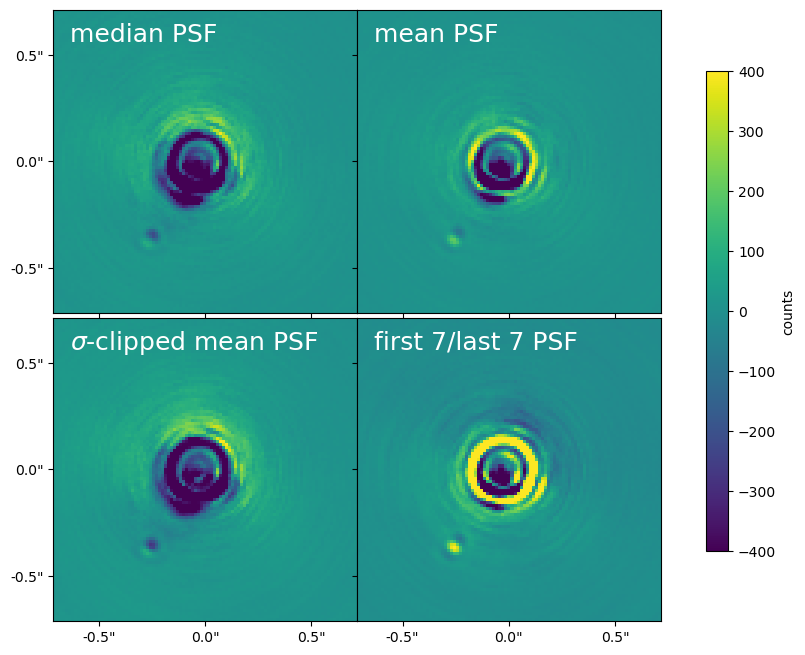

In [35]:
#plot the results of the 4 varieties of PSF construction
##NOTE: this compares the images produced for an arbitrarily-chosen wavelength slice
wslice = 15 #can modify to visualize wl effects

f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey=True, figsize=(9,8))
vmn=-400; vmx=400 #scale images to match cADI example
im1 = ax1.imshow(medim[wslice,mnx:mxx,mny:mxy], origin="lower", vmin=vmn, vmax=vmx)
add_label(ax1,"median PSF", stampsz)
im2 = ax2.imshow(meanim[wslice,mnx:mxx,mny:mxy], origin="lower", vmin=vmn, vmax=vmx)
add_label(ax2,"mean PSF", stampsz)
im3 = ax3.imshow(clipim[wslice,mnx:mxx,mny:mxy], origin="lower", vmin=vmn, vmax=vmx)
add_label(ax3,"$\sigma$-clipped mean PSF", stampsz)
im4 = ax4.imshow(bruteim[wslice,mnx:mxx,mny:mxy], origin="lower", vmin=vmn, vmax=vmx)
add_label(ax4,"first 7/last 7 PSF", stampsz)
plt.setp(ax1, xticks=ticks, xticklabels=ticklabels_str, yticks=ticks, yticklabels=ticklabels_str)
plt.subplots_adjust(wspace=0, hspace=0)
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.2, 0.025, 0.6])
cb = f.colorbar(im1, cax=cbar_ax,label="counts")

As the images above reveal, the radial shifting of the planet is minimal upon wavelength-rescaling. Most simply-constructed SDI reference PSFs thus have significant contributions of planet light throughout the radial range of the planet. Only by forcing the PSF to be constructed from a few images on opposite ends of the wavelength cube can we acheive a recovery with relatively little planet light in the PSF, though some radial self-subtraction is still apparent in the negative lobes on either side of the planet. 

## Exercise 4 - Practice SDI

Modify the wslice parameter in the cell above to get a sense for how the recovery of the planet and the degree of self-subtraction varies across the wavelength dimension of the cube. Describe the patterns you see in words, with figures to support your arguments. 

*Challenge exercises:*
* *Add an interactive wavelength slider to the function*
* *Play with the tunable paramters in the "clipped-mean" (parameter: sigma) and "brute" (parameter:nim) PSF constructions to see if you can improve the subtractions* 
* *Add your own, cleverer PSF construction technique and see if you can improve things further*

In [36]:
#your code here